<a href="https://colab.research.google.com/github/Aayush360/Data_Science_Intern/blob/master/Time_series_using_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## using FBProphet to model the data that has trend and is non-stationary (also has an holiday effect)
## notebook is an implementation of video lectures from AIEngineering

In [2]:
## notebook imports

In [19]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import plotly.express as px

from fbprophet import Prophet

mpl.rcParams['figure.figsize']= (10,8)
mpl.rcParams['axes.grid'] =False

In [6]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/amazon_revenue_profit.csv')
df_copy = raw_data.copy()

In [7]:
df_copy.head()

,Quarter,Revenue,Net Income
0,3/31/2020,75452,2535
1,12/31/2019,87437,3268
2,9/30/2019,69981,2134
3,6/30/2019,63404,2625
4,3/31/2019,59700,3561


In [9]:
df_copy.info() # let us convert the Quarter object to datetime

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Quarter     61 non-null     object
 1   Revenue     61 non-null     int64 
 2   Net Income  61 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.6+ KB


In [12]:
df_copy['Quarter'] = pd.to_datetime(df_copy['Quarter'],infer_datetime_format=True)
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Quarter     61 non-null     datetime64[ns]
 1   Revenue     61 non-null     int64         
 2   Net Income  61 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.6 KB


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7effb9767f98>,
      dtype=object)

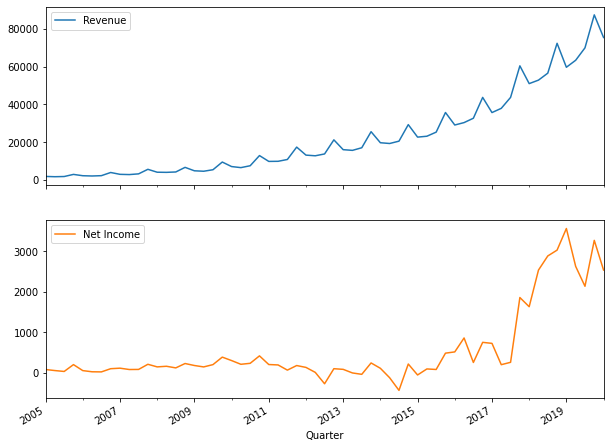

In [13]:
df = df_copy.set_index('Quarter')
df.plot(subplots=True)

In [15]:
## here we will try to predict the Revenue -- we can see that the revenue has distinct increasing trend and also the data seems like it is non-stationary

## the peak in the data tells us that the revenue is more during the month of dec-jan ,, holday season

In [18]:
fig = px.line(df_copy,x='Quarter',y='Revenue',title='Amazon_Profit')
fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons= list([
                       dict(count=1, label='1y', step='year',stepmode='backward'),
                       dict(count=2, label='2y', step='year', stepmode='backward'),
                       dict(count=3, label='3y',step='year', stepmode='backward'),
                       dict(step='all')
        ])
    )
)
fig.show()

In [21]:
## making a dataframe that we want to make analysis on,, i.e containg the revennue only
## renaming columns to Prophet compatile name

amazon_df = df_copy[['Quarter','Revenue']].rename({'Quarter':'ds','Revenue':'y'},axis='columns')
amazon_df

,ds,y
0,2020-03-31,75452
1,2019-12-31,87437
2,2019-09-30,69981
3,2019-06-30,63404
4,2019-03-31,59700
...,...,...
56,2006-03-31,2279
57,2005-12-31,2977
58,2005-09-30,1858
59,2005-06-30,1753


In [22]:
## splitting the data into training and test data

start_date = '2005-03-31'
end_date = '2019-03-31'

train_df = amazon_df[(amazon_df['ds']>=start_date)&(amazon_df['ds']<=end_date)]
test_df = amazon_df[(amazon_df['ds']>end_date)]

In [23]:
print('train_size',train_df.shape)
print('test_size',test_df.shape)

train_size (57, 2)
test_size (4, 2)


In [24]:
## First let us fit a simple prophet model with all arguments kept deafault and see how it performs

model = Prophet(interval_width=0.95)

In [25]:
model.fit(train_df)


INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [27]:
future_pred = model.make_future_dataframe(periods=test_df.shape[0], freq='Q')
future_pred.tail()

,ds
56,2019-03-31
57,2019-06-30
58,2019-09-30
59,2019-12-31
60,2020-03-31


In [28]:
prediction = model.predict(future_pred)
prediction[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
56,2019-03-31,61089.496722,57112.901283,65265.354082
57,2019-06-30,63195.117248,59310.415683,67276.775534
58,2019-09-30,66153.769201,62088.078811,70610.895581
59,2019-12-31,74249.538212,70113.208993,78244.491842
60,2020-03-31,70663.367647,66384.123089,74277.349712


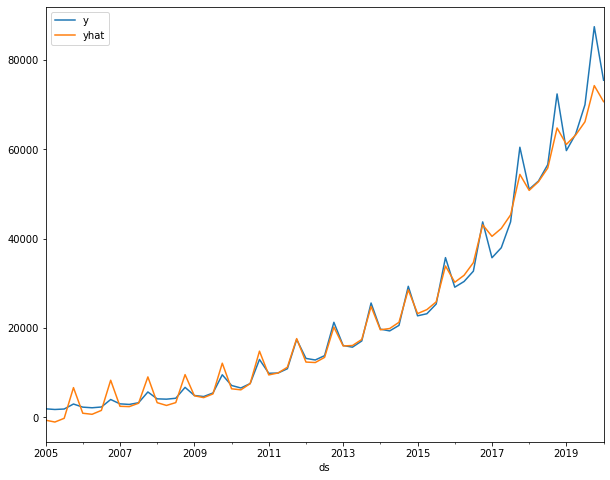

In [30]:
## plotting how our predcition differs from the actual prediction

pd.concat([amazon_df.set_index('ds')['y'], prediction.set_index('ds')['yhat']],axis=1).plot()

In [31]:
## we see that our model although fits resonably welll, it is unable to capture the trend,, non-statioanrity (extremen points that keep on incresing every year)
## may be providing addition informaiton to the model like holiday effecct could help model capture this informaiton...

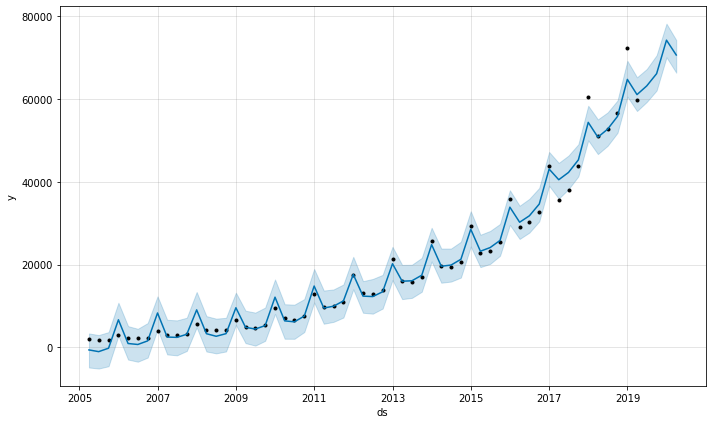

In [32]:
fig1= model.plot(prediction)

In [33]:
## the blue band shows the 95 percent confidence interval
## this shows the same information as the above plot,, black dots is the actual value
## all peaks predicted by our model is uniform ,, 

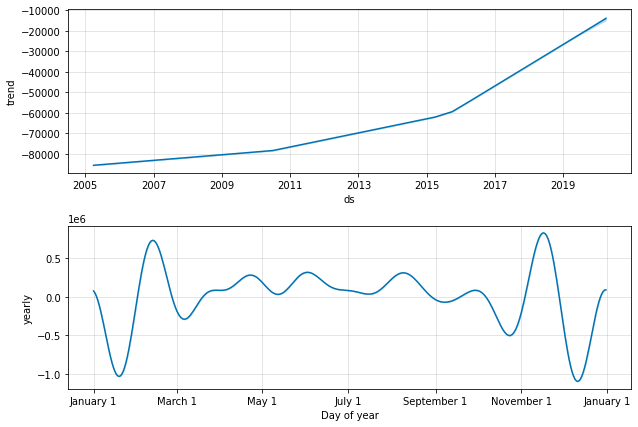

In [34]:
fig2 = model.plot_components(prediction)

In [35]:
## shows general incresing trend and yearly seasonal effect with high values for the moth of feb and nov-dec

In [36]:
## let us make holiday_dataframe and provide holiday information to the model before fitting the model

holiday_sale = pd.DataFrame({
    'holiday':'dec_jan_sale',
    'ds': pd.to_datetime(['2019-12-31','2018-12-31','2017-12-31',
                          '2016-12-31','2012-12-31','2011-12-31',
                          '2010-12-31','2009-12-31','2008-12-31',
                          '2007-12-31','2006-12-31','2005-12-31']),
    'lower_window':0,
    'upper_window':1
})

In [38]:
holiday_sale.head() ## the window_parameter shows how far does the holidy effect extends,, since we have yearly data in ds ,, we say it extends for only 1 period

,holiday,ds,lower_window,upper_window
0,dec_jan_sale,2019-12-31,0,1
1,dec_jan_sale,2018-12-31,0,1
2,dec_jan_sale,2017-12-31,0,1
3,dec_jan_sale,2016-12-31,0,1
4,dec_jan_sale,2012-12-31,0,1


In [39]:
## creating model with holiday_effect

model_hol = Prophet(interval_width=0.95, seasonality_mode='multiplicative',
                    holidays=holiday_sale)

In [41]:
model_hol.fit(train_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [43]:
prediction = model_hol.predict(future_pred)
prediction[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
56,2019-03-31,60253.759218,58595.101373,61991.485490
57,2019-06-30,62981.478489,61350.013404,64861.631069
58,2019-09-30,68047.570924,66283.809948,69753.739656
59,2019-12-31,87824.882763,85911.620851,89742.423122
60,2020-03-31,69795.587672,67933.855330,71810.252233


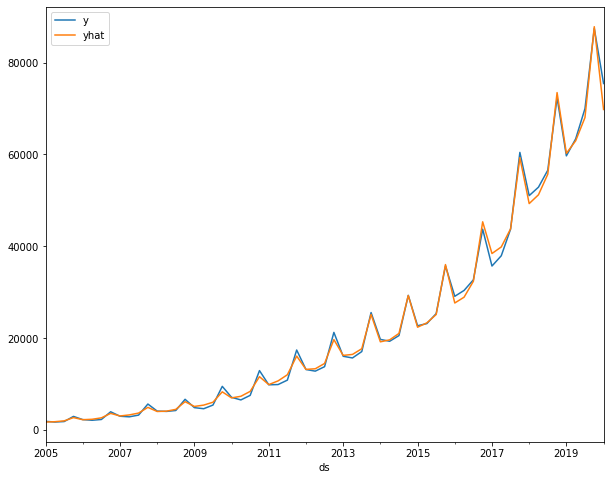

In [45]:
## let us compare this model with the actual values

pd.concat([amazon_df.set_index('ds')['y'], prediction.set_index('ds')['yhat']],axis=1).plot()

In [46]:
## now we can see that our model has been able to capture those extreme points as well i.e trends and non-stationarity
## thus providing extra informaiton like holiday_effect has indeed helped our model to make better prediction 

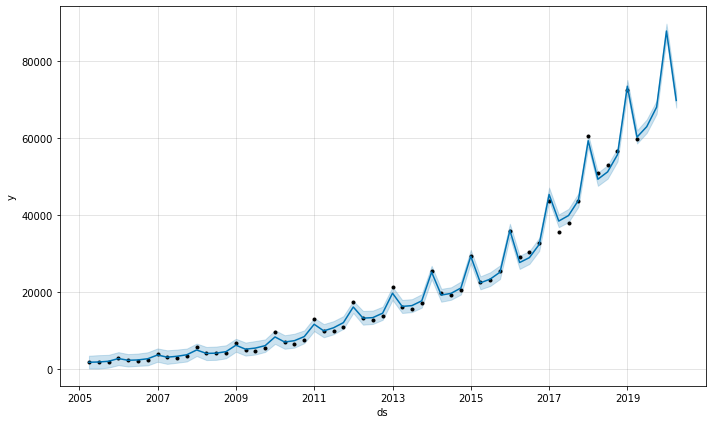

In [47]:
fig1 = model_hol.plot(prediction) # plot with confidence intreval 

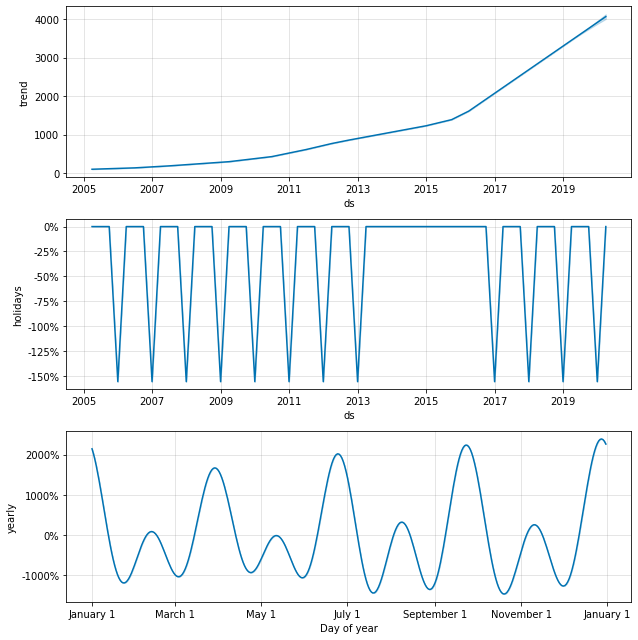

In [48]:
fig2 = model_hol.plot_components(prediction) # plot with compenets being decomposed